# Project 4: Ray Tracing Through a Lens

**Double tap this cell to get to edit mode and fill in the information below.**

> Full Name:

> Date:

> Resources Used:

## Tips

  * Python tutorials:
     * [A short introduction](https://realpython.com/python-first-steps/)
     * [A more complete introduction](https://www.w3schools.com/python/default.asp)
     * PythonMinimum
  * Use __esc r__ to disable a cell
  * Use __esc y__ to reactivate it
  * Use __esc m__ to go to markdown mode. **Markdown** is the typesetting language used in jupyter notebooks.
  * In a markdown cell, double tap the mouse or glide pad (on your laptop) to go to edit mode. 
  * Shift + return to execute a cell (including markdown cells).
  * If the equations don't typeset, try double tapping the cell again, and re-execute it.
  

## Learning Objectives
  * Learn how to use ray optics to trace light rays through a lens.
  * Discover the different behaviors of light rays through thick and thin lenses.
 
**Part 1** of this notebook contains programs you are free to use.

**Part 2** should contain your solution. 


## Introduction

In the rainbow project, you were introduced to **ray optics**. If we assume that losses due to reflection are media boundaries is negligible, then rhe tracing of rays through media of differing refractive indices is governed by a single rule:

  * The angle of transmission $\theta_t$ (otherwise known as the angle of refraction) satisfies **Snell's Law**, 
  
\begin{align}
  n_2 \sin\theta_t  & = n_1 \sin\theta_i ,
\end{align}

where $n_1$ is the refractive index of the medium through which the incident ray travels and $n_2$ is the refractive index of the medium containing the transmitted (refracted) ray. By convention, all angles are measured with respect to the normal $\hat{n}$ to the boundary.

## Project Goal

An orange LED a placed at $\vec{c} = (-8, 0, 0)$ with the lens at the origin.

  1. Complete the ray tracing program in Part 2 for a glass lens defined by the intersection of two spherical surfaces, of radii $a_1$ (`a1`) and $a_2$ (`a2`), which intersect at $x = 0$. 
  1. Trace and plot the rays given in Part 2 through the lens and answer the questions below.
  
## Assumptions
  1. Ignore reflections at the boundaries.
  1. The refractive index of air is 1.0
  1. The refractive index of the glass is 1.5
  1. The diameter of the lens is $d = 6\text{cm}$.
  1. For the thick lens the surface on the left (surface 1) has radius $a_1 = 3 \text{ cm}$, while that on the right (surface 2) has radius $a_2 = 6 \text{ cm}$. The **centers of curvature** (that is, the positions of the centers of the two intersecting spheres) for surface 1 and surface 2 are $\vec{c}_1 = (x_1, 0, 0)$ and $\vec{c}_2 = (-x_2, 0, 0)$, respectively, where $x_i = \sqrt{a_i^2 - (d/2)^2}, i = 1, 2$.

## Questions
  1. **Thick lens**: Do the rays cross at the same point?
  1. **Thin lens**: Consider a new lens with the same diameter $d$, but this time with surfaces that have the *same* radius of curvature `R`. Starting from $R=3$ cm (that is, a spherical lens), gradually increase $R$ until the rays transmitted through the lens are judged to be as parallel as possible. 
     1. What value did you get for $R$?
     1. If parallel rays were incident on this lens from the right, what would happen to the rays?

In [2]:
import os, sys
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

%matplotlib inline

# update fonts
FONTSIZE = 12
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# use latex if available on system, otherwise set usetex=False
mp.rc('text', usetex=True)

### Import functions from CompPhysLab module `computil.vectors`

In [3]:
from computil.vectors import magnitude, norm, dot, \
tangent, reflection, transmission, line_sphere_intersect

# Part 1

Functions from `computil.vectors` can operate on one more more vectors.

  1. `dot(a, b)`: dot product.
  1. `tangent(u, n)`: given incident unit vector `u` and normal unit vector `n` return the  unit vector `nt` tangent to `n` and that lies in the plane defined by `u` and `n`.
  1. `reflection(u, n)`: given incident unit vector `u` and normal unit vector `n` return the reflection unit vector `ur`.
  1. `transmission(u, n, n1, n2)`: given incident unit vector `u`, normal unit vector `n`, and refractive indices `n1` and `n2`, return the transmission unit vector `ut`.
  1. `line_sphere_intersect(c, u, a, o)`, return the intersection points of a line, specified by a point `c` and unit vector `u`, and a sphere of radius `a` centered at point `o`.

### Define Lens

In [4]:
def center_of_curvature(a, d, positive):
    x = np.sqrt(a**2 - (d/2)**2)
    if not positive:
        x = -x
    y = 0
    z = 0
    c = np.array([x, y, z])
    return c

In [5]:
d  = 6 # diameter of lens (cm)

# surface 1
# ---------
a1 = 3.0  # radius of curvature (cm)
c1 = center_of_curvature(a1, d, positive=True) # positive x-axis
print(f'surface 1(center): ', c1)

# surface 2
# ---------
a2 = 6.0  # radius of curvature (cm)
c2 = center_of_curvature(a2, d, positive=False) # negative x-axis
print(f'surface 2(center): ', c2)

# refractive indices
# ------------------
n1 = 1.0
n2 = 1.5

# LED
# ---
LED_position = np.array([-8, 0, 0])
LED_color = 'orange'


surface 1(center):  [0. 0. 0.]
surface 2(center):  [-5.19615242  0.          0.        ]


Outline of lens is formed from a sequence of points that form a polygon. The polygon starts at the bottom of the lens, goes up surface 1 to the top of the lens the continues down surface 2 to the bottom of the lens.

In [6]:
def construct_lens(A1, C1, A2, C2, K=101):
   
    # compute points on surface 1 from bottom to top
    x    = np.abs(C1[0])
    angle= np.arccos(x/A1)
    phi1 = np.pi - angle
    phi2 = phi1 + 2*angle
    phi  = np.linspace(phi1, phi2, K)
    x1   = C1[0] + A1 * np.cos(phi)
    y1   = C1[1] + A1 * np.sin(phi)

    # compute points on surface 2 from top to bottom
    x    = np.abs(C2[0])
    angle= np.arccos(x/A2)
    phi1 =-angle
    phi2 = angle
    phi  = np.linspace(phi1, phi2, K)
    
    # order points from top to bottom
    phi  = np.flip(phi, axis=0)
    x2   = C2[0] + A2 * np.cos(phi)
    y2   = C2[1] + A2 * np.sin(phi)

    # now join arrays of points to form closed polygon
    x  = np.concatenate((x1, x2), axis=0)
    y  = np.concatenate((y1, y2), axis=0)
    xy = np.array(list(zip(x, y)))
    
    return xy

### A few useful plotting utilities

In [7]:
# create a figure with a single subplot
def setup_figure(Xmin, Xmax, Ymin, Ymax, Fgsize, Ftsize):

    Fig, Ax = plt.subplots(nrows=1, ncols=1, figsize=Fgsize)
        
    # annotate plot
    Ax.set_xlim(Xmin, Xmax)
    Ax.set_ylim(Ymin, Ymax)
    Ax.set_xlabel(r'$x$', fontsize=Ftsize)
    Ax.set_ylabel(r'$y$', fontsize=Ftsize)
    Ax.set_aspect(1)
    
    return Fig, Ax
        
# plot one of more line segments from point c to point p
def draw_line_segments(Ax, C, P, Colors, Lstyle='solid'):
    try:
        for p1, p2, c in zip(C, P, Colors):
            x = [p1[0], p2[0]]
            y = [p1[1], p2[1]]
            Ax.plot(x, y, color=c, linestyle=Lstyle)
    except:
        x = [C[0], P[0]]
        y = [C[1], P[1]]
        Ax.plot(x, y, color=Colors, linestyle=Lstyle)
        
def draw_axes(Ax, Xmin, Xmax, Ymin, Ymax, Color='grey', Lstyle='dashed'):
    x = [Xmin, Xmax]
    y = [0, 0]
    Ax.plot(x, y, color=Color, linestyle=Lstyle)
    
    x = [0, 0]
    y = [Ymin, Ymax]
    Ax.plot(x, y, color=Color, linestyle=Lstyle)
    
def draw_led(Ax, Led_pos, Led_color):
    x = [Led_pos[0]]
    y = [Led_pos[1]]
    Ax.scatter(x, y, color=Led_color, s=20)

def draw_lens(Ax, A1, O1, A2, O2, Lens_color='lightblue'):
    xy   = construct_lens(A1, O1, A2, O2)
    lens = plt.Polygon(xy, color=Lens_color)
    Ax.add_patch(lens)
    
def draw_sphere(Ax, A, C):
    x = [C[0]]
    y = [C[1]]
    Ax.scatter(x, y, color='black', s=20)
    
    phi  = np.linspace(0, 2*np.pi, 100)
    x = C[0] + A * np.cos(phi)
    y = C[1] + A * np.sin(phi)
    Ax.plot(x, y, color='grey', linewidth=0.2)

### Check that shape of lens is correctly computed

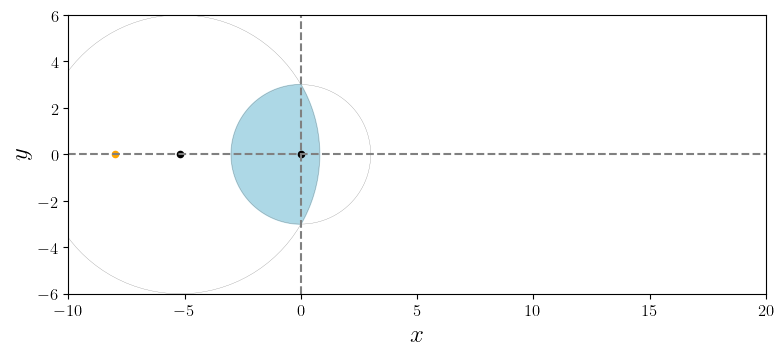

In [8]:
def plot_lens(led_pos, led_color, a1, o1, a2, o2, 
              xmin=-10.0, xmax=20.0,
              ymin=-6.0, ymax=6.0,
              gfile='fig_lens.png', 
              fgsize=(8, 4), 
              ftsize=18):
       
    fig, ax = setup_figure(xmin, xmax, ymin, ymax, fgsize, ftsize)
    
    draw_axes(ax, xmin, xmax, ymin, ymax)
    
    draw_led(ax, led_pos, led_color)

    draw_lens(ax, a1, o1, a2, o2)
    
    # draw center of curvature of surface 2
    # and indicate the associated sphere
    draw_sphere(ax, a1, o1)
    draw_sphere(ax, a2, o2)
    
    plt.tight_layout()
    plt.savefig(gfile)
    plt.show()
    
    
plot_lens(LED_position, LED_color, a1, c1, a2, c2)

# Part 2

  1. Complete the ray tracing program in Part 2 for a glass lens defined by the intersection of two spherical surfaces, of radii $a_1$ (`a1`) and $a_2$ (`a2`), which intersect at $x = 0$. 
  1. Trace and plot the rays given in Part 2 through the lens and answer the questions below.

## Questions
  1. **Thick lens**: Do the rays cross at the same point?
  1. **Thin lens**: Gradually increase $a_1$ (and set $a_2 = a_1$) until the rays transmitted through the lens are parallel. 
     1. What value did you get for $a_1$?
     1. If parallel rays were incident from the right, what would happen to the rays?

### Incident Rays

Each ray is define by the vector

$$\vec{r} = \lambda \hat{u} + \vec{c}.$$

In [9]:
UNIT_VECTORS = '''
      [[ 0.9403848 , -0.34011238,  0.        ],
       [ 0.95217901, -0.30554072,  0.        ],
       [ 0.96270273, -0.27056137,  0.        ],
       [ 0.97194191, -0.23522101,  0.        ],
       [ 0.97988422, -0.1995668 ,  0.        ],
       [ 0.98651908, -0.16364631,  0.        ],
       [ 0.99183761, -0.12750746,  0.        ],
       [ 0.99583274, -0.09119847,  0.        ],
       [ 0.99849912, -0.0547678 ,  0.        ],
       [ 0.9998332 , -0.01826406,  0.        ],
       [ 0.9998332 ,  0.01826406,  0.        ],
       [ 0.99849912,  0.0547678 ,  0.        ],
       [ 0.99583274,  0.09119847,  0.        ],
       [ 0.99183761,  0.12750746,  0.        ],
       [ 0.98651908,  0.16364631,  0.        ],
       [ 0.97988422,  0.1995668 ,  0.        ],
       [ 0.97194191,  0.23522101,  0.        ],
       [ 0.96270273,  0.27056137,  0.        ],
       [ 0.95217901,  0.30554072,  0.        ],
       [ 0.9403848 ,  0.34011238,  0.        ]]
'''.strip()

u = eval(UNIT_VECTORS)

u

[[0.9403848, -0.34011238, 0.0],
 [0.95217901, -0.30554072, 0.0],
 [0.96270273, -0.27056137, 0.0],
 [0.97194191, -0.23522101, 0.0],
 [0.97988422, -0.1995668, 0.0],
 [0.98651908, -0.16364631, 0.0],
 [0.99183761, -0.12750746, 0.0],
 [0.99583274, -0.09119847, 0.0],
 [0.99849912, -0.0547678, 0.0],
 [0.9998332, -0.01826406, 0.0],
 [0.9998332, 0.01826406, 0.0],
 [0.99849912, 0.0547678, 0.0],
 [0.99583274, 0.09119847, 0.0],
 [0.99183761, 0.12750746, 0.0],
 [0.98651908, 0.16364631, 0.0],
 [0.97988422, 0.1995668, 0.0],
 [0.97194191, 0.23522101, 0.0],
 [0.96270273, 0.27056137, 0.0],
 [0.95217901, 0.30554072, 0.0],
 [0.9403848, 0.34011238, 0.0]]

In [10]:
# convert to numpy array
u = np.array(u)

# number of rays
nrays = len(u)

# define point on rays
c = np.array([LED_position] * nrays) # all rays start from the LED

# define colors of rays
colors = [LED_color] * nrays

c.shape, u.shape

((20, 3), (20, 3))

### Tracing rays through a Lens

  1. `c`: a point on the incident ray (an array of vectors)
  1. `u`: a unit vector defining th direction of the incident ray (an array of vectors)
  1. `d`: diameter of lens (cm).
  1. `a1`: radius of curvature of surface 1 (on the left)
  1. `o1`: center of curvature of surface 1
  1. `a2`: radius of curvature of surface 2 (on the right)
  1. `o2`: center of curvature of surface 2
  1. `n1`: the refractive index of medium in which incident ray is propagating.
  1. `n2`: the refractive index of medium in which transmitted ray is propagating.
  1. `colors`: colors of the rays.

In [11]:
help(line_sphere_intersect)

Help on function line_sphere_intersect in module computil.vectors:

line_sphere_intersect(c, u, a, o)
    Given a line defined by the point c and unit vector u, compute the points of intersection
    with a sphere or radius a located at point o.
    
    Arguments
    ---------
    c :   a point on the incident ray (or a numpy array of vectors)
    u :   a unit vector in the direction of the incident ray (or a numpy array of vectors)
    a :   the radius of the sphere
    o :   the location of center of the sphere (i.e., the center of curvature)
    
    Return
    ------
    p1, p2, crosses : p1 and p2 are the intersection points, with p1 the closer of the two points to
    point c and crosses are an array of booleans. If True, the line crosses the sphere.
    
    Example
    -------
    
    p1, p2, crosses = line_sphere_intersect(C, U, R, O)



In [12]:
def plot_rays_thru_lens(c, u, d, a1, o1, a2, o2, n1, n2, colors, 
                        xmin=-10.0, xmax=20.0,
                        ymin=-6.0, ymax=6.0,
                        gfile='fig_ray_tracing_thru_lens.png', 
                        fgsize=(8, 4), 
                        ftsize=18):

    fig, ax = setup_figure(xmin, xmax, ymin, ymax, fgsize, ftsize)
    
    draw_axes(ax, xmin, xmax, ymin, ymax)
    
    led_pos = c[0]
    led_color = colors[0]
    draw_led(ax, led_pos, led_color)

    draw_lens(ax, a1, o1, a2, o2)
    
    # 1. compute the intersection of incident rays with surface 1
    #    --------------------------------------------------------
    
    
    # 2. draw incident rays from c to intersection points at
    #    surface 1


    
    # 3. compute unit normals to surface 1 at intersection points, 
    #    with the convention that the normals point away from the 
    #    center of curvature
    


    # 4. compute transmission unit vectors at surface 1
    

    
    # 5. compute intersection of transmitted rays (which become 
    #    the new incident rays) with surface 2 and use the 
    #    previous intersection points as the points "c" for 
    #    the new incident rays.
    #    --------------------------------------------------------

    

    # 6. compute unit normals to surface 2 at intersection points, 
    #    with the convention that the normals point away from the 
    #    center of curvature

    
   
    # 7. draw new incident rays from c to intersection points at
    #    surface 2

    
    # 8. compute transmission unit vectors at surface 2. Hint: what
    #    must you do to the refractive indices?


    
    # 9. draw transmitted rays from the intersection points at
    #    surface 2 to points q that are 30 cm away from the
    #    intersection points
    

    
    plt.tight_layout()
    plt.savefig(gfile)
    plt.show()

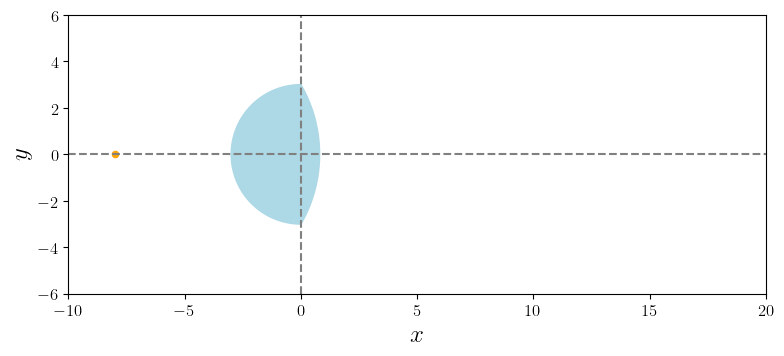

In [13]:
plot_rays_thru_lens(c, u, d, a1, c1, a2, c2, n1, n2, colors)

## Questions
  1. **Thick lens**: Do the rays cross at the same point?
  1. **Thin lens**: Consider a new lens with the same diameter $d$, but this time with surfaces that have the *same* radius of curvature `R`. Starting from $R=3$ cm (that is, a spherical lens), gradually increase $R$ until the rays transmitted through the lens are judged to be as parallel as possible. 
     1. What value did you get for $R$?
     1. If parallel rays were incident on this lens from the right, what would happen to the rays?